In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA = Path("../data/telemetry.csv")
df = pd.read_csv(DATA)

assert set(df.columns) == {
    "timestamp","x","y","vx","vy","action","ping_ms","cheat_flag"
}

# Basic features
df["speed"] = np.sqrt(df["vx"]**2 + df["vy"]**2)
df["accel_x"] = df["vx"].diff().fillna(0)
df["accel_y"] = df["vy"].diff().fillna(0)
df["accel_mag"] = np.sqrt(df["accel_x"]**2 + df["accel_y"]**2)

# Small rolling context (captures local spikes)
df["speed_roll_mean"] = df["speed"].rolling(5, min_periods=1).mean()
df["speed_roll_std"]  = df["speed"].rolling(5, min_periods=1).std().fillna(0)

df.head()


,timestamp,x,y,vx,vy,action,ping_ms,cheat_flag,speed,accel_x,accel_y,accel_mag,speed_roll_mean,speed_roll_std
0,8.300000e-08,0.515433,-0.550234,0.515433,-0.550234,2,37,0,0.753942,0.000000,0.000000,0.000000,0.753942,0.000000
1,5.438700e-02,2.657090,-1.748040,2.141660,-1.197810,2,52,0,2.453866,1.626227,-0.647576,1.750420,1.603904,1.202027
2,1.086780e-01,2.164290,-3.759000,-0.492803,-2.010960,3,69,0,2.070462,-2.634463,-0.813150,2.757101,1.759423,0.891624
3,1.628460e-01,2.328450,-4.241620,0.164165,-0.482619,1,53,0,0.509776,0.656968,1.528341,1.663560,1.447011,0.959375
4,2.159340e-01,1.900660,-4.219400,-0.427793,0.022222,2,57,0,0.428370,-0.591958,0.504841,0.777996,1.243283,0.947537


Matplotlib is building the font cache; this may take a moment.


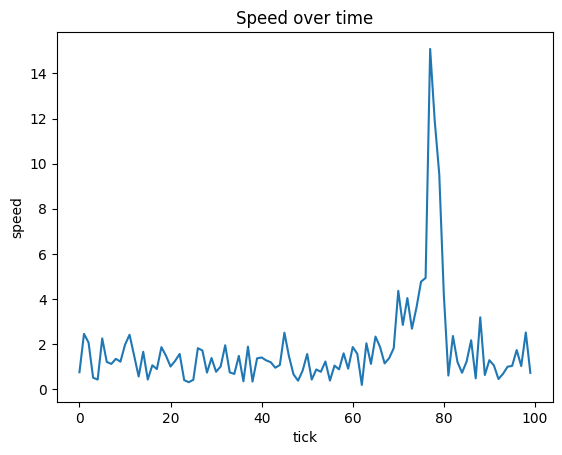

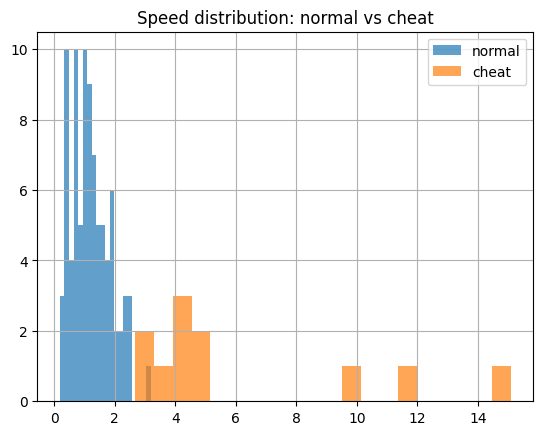

In [4]:
import matplotlib.pyplot as plt

plt.figure()
df["speed"].plot(title="Speed over time")
plt.xlabel("tick"); plt.ylabel("speed")
plt.show()

plt.figure()
df.loc[df["cheat_flag"]==0,"speed"].hist(alpha=0.7, bins=20, label="normal")
df.loc[df["cheat_flag"]==1,"speed"].hist(alpha=0.7, bins=20, label="cheat")
plt.legend(); plt.title("Speed distribution: normal vs cheat")
plt.show()

In [5]:
features = ["speed","accel_mag","speed_roll_mean","speed_roll_std","ping_ms","action"]
X = df[features].values
y = df["cheat_flag"].values

split = int(len(df)*0.7)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [6]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

iso = IsolationForest(
    n_estimators=200,
    contamination="auto",
    random_state=42,
)
iso.fit(X_train)

# IsolationForest gives -1 for outliers, 1 for inliers
pred_train = (iso.predict(X_train) == -1).astype(int)  # 1 = predicted cheat
pred_test  = (iso.predict(X_test)  == -1).astype(int)

cm = confusion_matrix(y_test, pred_test, labels=[0,1])
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary", pos_label=1)
cm, prec, rec, f1


(array([[ 5, 14],
        [ 0, 11]]),
 0.44,
 1.0,
 0.6111111111111112)

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, average_precision_score

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=500, class_weight="balanced", random_state=42))
])
logreg.fit(X_train, y_train)

proba_test = logreg.predict_proba(X_test)[:,1]
pred_test  = (proba_test >= 0.5).astype(int)

cm = confusion_matrix(y_test, pred_test, labels=[0,1])
prec, rec, f1, _ = precision_recall_fscore_support(y_test, pred_test, average="binary", pos_label=1)
roc = roc_auc_score(y_test, proba_test)
pr_auc = average_precision_score(y_test, proba_test)

print("CM:\n", cm)
print(f"precision={prec:.3f} recall={rec:.3f} f1={f1:.3f} ROC-AUC={roc:.3f} PR-AUC={pr_auc:.3f}")


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)

In [ ]:
threshold = 0.35  # try 0.3..0.6 based on your goals
pred_test = (proba_test >= threshold).astype(int)


In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_test, proba_test)
precisions, recalls, _ = precision_recall_curve(y_test, proba_test)

plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--'); plt.title("ROC")
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.show()

plt.figure(); plt.plot(recalls, precisions); plt.title("Precision-Recall")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.show()

In [ ]:
import joblib, time, os
os.makedirs("../models", exist_ok=True)
ts = time.strftime("%Y%m%d_%H%M%S")

joblib.dump(iso,    f"../models/iso_{ts}.joblib")
joblib.dump(logreg, f"../models/logreg_{ts}.joblib")
print("Saved models to ../models/")

In [ ]:
with open("../models/feature_order.txt","w") as f:
    f.write("\n".join(features))

In [ ]:
import json
from sklearn.linear_model import LogisticRegression

clf = logreg.named_steps["clf"]
scaler = logreg.named_steps["scaler"]

export = {
  "type": "logistic_regression",
  "features": features,
  "scaler_mean": scaler.mean_.tolist(),
  "scaler_scale": scaler.scale_.tolist(),
  "coef": clf.coef_[0].tolist(),
  "intercept": float(clf.intercept_[0]),
  "decision_threshold": 0.5  # tune as needed
}
with open("../models/logreg_export.json","w") as f:
    json.dump(export, f, indent=2)
print("Wrote ../models/logreg_export.json")